In [1]:
%matplotlib inline


Core Concepts
=============

This tutorial introduces Documents, Corpora, Vectors and Models: the basic concepts and terms needed to understand and use gensim.



In [2]:
import pprint

The core concepts of ``gensim`` are:

1. `core_concepts_document`: some text.
2. `core_concepts_corpus`: a collection of documents.
3. `core_concepts_vector`: a mathematically convenient representation of a document.
4. `core_concepts_model`: an algorithm for transforming vectors from one representation to another.

Let's examine each of these in slightly more detail.


Document
--------

In Gensim, a *document* is an object of the `text sequence type <https://docs.python.org/3.7/library/stdtypes.html#text-sequence-type-str>`_ (commonly known as ``str`` in Python 3).
A document could be anything from a short 140 character tweet, a single
paragraph (i.e., journal article abstract), a news article, or a book.




In [ ]:
# some-text
document = "Human machine interface for lab abc computer applications"


Corpus
------

A *corpus* is a collection of `core_concepts_document` objects.
Corpora serve two roles in Gensim:

1. Input for training a `core_concepts_model`.
   During training, the models use this *training corpus* to look for common
   themes and topics, initializing their internal model parameters.

   Gensim focuses on *unsupervised* models so that no human intervention,
   such as costly annotations or tagging documents by hand, is required.

2. Documents to organize.
   After training, a topic model can be used to extract topics from new
   documents (documents not seen in the training corpus).

   Such corpora can be indexed for
   `sphx_glr_auto_examples_core_run_similarity_queries.py`,
   queried by semantic similarity, clustered etc.

Here is an example corpus.
It consists of 9 documents, where each document is a string consisting of a single sentence.




In [3]:
# a collection of document
text_corpus = [
    "Human machine interface for lab abc computer applications",
    "A survey of user opinion of computer system response time",
    "The EPS user interface management system",
    "System and human system engineering testing of EPS",
    "Relation of user perceived response time to error measurement",
    "The generation of random binary unordered trees",
    "The intersection graph of paths in trees",
    "Graph minors IV Widths of trees and well quasi ordering",
    "Graph minors A survey",
]

.. Important::
  The above example loads the entire corpus into memory.
  In practice, corpora may be very large, so loading them into memory may be impossible.
  Gensim intelligently handles such corpora by *streaming* them one document at a time.
  See `corpus_streaming_tutorial` for details.

This is a particularly small example of a corpus for illustration purposes.
Another example could be a list of all the plays written by Shakespeare, list
of all wikipedia articles, or all tweets by a particular person of interest.

After collecting our corpus, there are typically a number of preprocessing
steps we want to undertake. We'll keep it simple and just remove some
commonly used English words (such as 'the') and words that occur only once in
the corpus. In the process of doing so, we'll tokenize our data.
Tokenization breaks up the documents into words (in this case using space as
a delimiter).

.. Important::
  There are better ways to perform preprocessing than just lower-casing and
  splitting by space.  Effective preprocessing is beyond the scope of this
  tutorial: if you're interested, check out the
  :py:func:`gensim.utils.simple_preprocess` function.




In [13]:
# Create a set of frequent words
stoplist = set('for a of the and to in'.split(' '))

# Lowercase each document, split it by white space and filter out stopwords
texts = [[word for word in document.lower().split() if word not in stoplist]
         for document in text_corpus]

# Count word frequencies
from collections import defaultdict
frequency = defaultdict(int)
for text in texts:  # 遍历每个 doc_word_list
    for token in text: # 遍历具体某个词
        frequency[token] += 1

# Only keep words that appear more than once
processed_corpus = [[token for token in text if frequency[token] > 1] for text in texts]
pprint.pprint(processed_corpus)


[['human', 'interface', 'computer'],
 ['survey', 'user', 'computer', 'system', 'response', 'time'],
 ['eps', 'user', 'interface', 'system'],
 ['system', 'human', 'system', 'eps'],
 ['user', 'response', 'time'],
 ['trees'],
 ['graph', 'trees'],
 ['graph', 'minors', 'trees'],
 ['graph', 'minors', 'survey']]


Before proceeding, we want to associate each word in the corpus with a unique
integer ID. We can do this using the :py:class:`gensim.corpora.Dictionary`
class.  This dictionary defines the vocabulary of all words that our
processing knows about.




In [21]:
from gensim import corpora


# we want to associate each word in the corpus with a unique integer ID
dictionary = corpora.Dictionary(processed_corpus)
for item in dictionary.items():
    print(item[0], item[1], sep='=')
print(dictionary)

0=computer
1=human
2=interface
3=response
4=survey
5=system
6=time
7=user
8=eps
9=trees
10=graph
11=minors
Dictionary(12 unique tokens: ['computer', 'human', 'interface', 'response', 'survey']...)


Because our corpus is small, there are only 12 different tokens in this
:py:class:`gensim.corpora.Dictionary`. For larger corpuses, dictionaries that
contains hundreds of thousands of tokens are quite common.





Vector
------

To infer the latent structure in our corpus we need a way to represent
documents that we can manipulate mathematically. One approach is to represent
each document as a vector of *features*.
For example, a single feature may be thought of as a question-answer pair:

1. How many times does the word *splonge* appear in the document? Zero.
2. How many paragraphs does the document consist of? Two.
3. How many fonts does the document use? Five.

The question is usually represented only by its integer id (such as `1`, `2` and `3`).
The representation of this document then becomes a series of pairs like ``(1, 0.0), (2, 2.0), (3, 5.0)``.
This is known as a *dense vector*, because it contains an explicit answer to each of the above questions.

If we know all the questions in advance, we may leave them implicit
and simply represent the document as ``(0, 2, 5)``.
This sequence of answers is the **vector** for our document (in this case a 3-dimensional dense vector).
For practical purposes, only questions to which the answer is (or
can be converted to) a *single floating point number* are allowed in Gensim.

In practice, vectors often consist of many zero values.
To save memory, Gensim omits all vector elements with value 0.0.
The above example thus becomes ``(2, 2.0), (3, 5.0)``.
This is known as a *sparse vector* or *bag-of-words vector*.
The values of all missing features in this sparse representation can be unambiguously resolved to zero, ``0.0``.

Assuming the questions are the same, we can compare the vectors of two different documents to each other.
For example, assume we are given two vectors ``(0.0, 2.0, 5.0)`` and ``(0.1, 1.9, 4.9)``.
Because the vectors are very similar to each other, we can conclude that the documents corresponding to those vectors are similar, too.
Of course, the correctness of that conclusion depends on how well we picked the questions in the first place.

Another approach to represent a document as a vector is the *bag-of-words
model*.
Under the bag-of-words model each document is represented by a vector
containing the frequency counts of each word in the dictionary.
For example, assume we have a dictionary containing the words
``['coffee', 'milk', 'sugar', 'spoon']``.
A document consisting of the string ``"coffee milk coffee"`` would then
be represented by the vector ``[2, 1, 0, 0]`` where the entries of the vector
are (in order) the occurrences of "coffee", "milk", "sugar" and "spoon" in
the document. The length of the vector is the number of entries in the
dictionary. One of the main properties of the bag-of-words model is that it
completely ignores the order of the tokens in the document that is encoded,
which is where the name bag-of-words comes from.

Our processed corpus has 12 unique words in it, which means that each
document will be represented by a 12-dimensional vector under the
bag-of-words model. We can use the dictionary to turn tokenized documents
into these 12-dimensional vectors. We can see what these IDs correspond to:




In [22]:
# 每个token 绑定一个对应的 int id
# Our processed corpus has 12 unique words in it, 
# which means that each document will be represented by a 12-dimensional 
# vector under the bag-of-words model.
pprint.pprint(dictionary.token2id)



{'computer': 0,
 'eps': 8,
 'graph': 10,
 'human': 1,
 'interface': 2,
 'minors': 11,
 'response': 3,
 'survey': 4,
 'system': 5,
 'time': 6,
 'trees': 9,
 'user': 7}


For example, suppose we wanted to vectorize the phrase "Human computer
interaction" (note that this phrase was not in our original corpus). We can
create the bag-of-word representation for a document using the ``doc2bow``
method of the dictionary, which returns a sparse representation of the word
counts:




In [23]:
# bow -> bag of word,  dense vector -> sparse vector : a question-answer pair

# (1, 0.0), (2, 2.0), (3, 5.0)  -> dense vector ， 用于描述一个文档
# the question is usually represented only by its integer id (such as 1, 2 and 3), 
# 第一个是问题的编号,第二个entry的答案

# (0,2,5) -> 3-dimensional dense vector, simply represent, 将答案存储在一个vector中

# sparse vector -> In practice, vectors often consist of many zero values, 
# the values of all missing features in this sparse representation can be unambiguously
# resolved to zero, (0.0) sparse vector, 节省内存

# The first entry in each tuple corresponds to the ID of the token in the dictionary, 
# the second corresponds to the count of this token.

new_doc = "Human computer interaction"
new_vec = dictionary.doc2bow(new_doc.lower().split())
# returns a sparse representation of the word counts
print(new_vec)

[(0, 1), (1, 1)]


The first entry in each tuple corresponds to the ID of the token in the
dictionary, the second corresponds to the count of this token.

Note that "interaction" did not occur in the original corpus and so it was
not included in the vectorization. Also note that this vector only contains
entries for words that actually appeared in the document. Because any given
document will only contain a few words out of the many words in the
dictionary, words that do not appear in the vectorization are represented as
implicitly zero as a space saving measure.

We can convert our entire original corpus to a list of vectors:




In [27]:
# doc -> vector 练习
from gensim.corpora import Dictionary
dct = Dictionary(["máma mele maso".split(), "ema má máma".split()])
# print(dct.token2id)

bow_1 = dct.doc2bow(["this", "is", "máma", "máma","máma"])
bow_1 # (token_id, token_count)

# [(2, 1)]

bow_2 = dct.doc2bow(["this", "is", "máma"], return_missing=True)
bow_2
# ([(2, 1)], {u'this': 1, u'is': 1})

            
            

([(2, 1)], {'is': 1, 'this': 1})

In [28]:
# We can convert our entire original corpus to a list of vectors:
bow_corpus = [dictionary.doc2bow(text) for text in processed_corpus]
pprint.pprint(bow_corpus)



[[(0, 1), (1, 1), (2, 1)],
 [(0, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)],
 [(2, 1), (5, 1), (7, 1), (8, 1)],
 [(1, 1), (5, 2), (8, 1)],
 [(3, 1), (6, 1), (7, 1)],
 [(9, 1)],
 [(9, 1), (10, 1)],
 [(9, 1), (10, 1), (11, 1)],
 [(4, 1), (10, 1), (11, 1)]]


Note that while this list lives entirely in memory, in most applications you
will want a more scalable solution. Luckily, ``gensim`` allows you to use any
iterator that returns a single document vector at a time. See the
documentation for more details.

.. Important::
  The distinction between a document and a vector is that the former is text,
  and the latter is a mathematically convenient representation of the text.
  Sometimes, people will use the terms interchangeably: for example, given
  some arbitrary document ``D``, instead of saying "the vector that
  corresponds to document ``D``", they will just say "the vector ``D``" or
  the "document ``D``".  This achieves brevity at the cost of ambiguity.

  As long as you remember that documents exist in document space, and that
  vectors exist in vector space, the above ambiguity is acceptable.

.. Important::
  Depending on how the representation was obtained, two different documents
  may have the same vector representations.


Model
-----

Now that we have vectorized our corpus we can begin to transform it using
*models*. We use model as an abstract term referring to a *transformation* from
one document representation to another. In ``gensim`` documents are
represented as vectors so a model can be thought of as a transformation
between two vector spaces. The model learns the details of this
transformation during training, when it reads the training
`core_concepts_corpus`.

One simple example of a model is `tf-idf
<https://en.wikipedia.org/wiki/Tf%E2%80%93idf>`_.  The tf-idf model
transforms vectors from the bag-of-words representation to a vector space
where the frequency counts are weighted according to the relative rarity of
each word in the corpus.

Here's a simple example. Let's initialize the tf-idf model, training it on
our corpus and transforming the string "system minors":




In [33]:
# model 的理解： a transformation between two vector spaces
# The model learns the details of this transformation during 
# training, when it reads the training Corpus.

from gensim import models

# train the model
tfidf = models.TfidfModel(bow_corpus)

# transform the "system minors" string
words = "system minors".lower().split()
doc_vec = dictionary.doc2bow(words)

# the first entry is the token ID and the second entry is the tf-idf weighting
# Note that the ID corresponding to “system” (which occurred 4 times in the original corpus) 
# has been weighted lower than the ID corresponding to “minors” (which only occurred twice).
print(tfidf[doc_vec], doc_vec)

import pandas as pd

pd.DataFrame().sort_values




[(5, 0.5898341626740045), (11, 0.8075244024440723)] [(5, 1), (11, 1)]


The ``tfidf`` model again returns a list of tuples, where the first entry is
the token ID and the second entry is the tf-idf weighting. Note that the ID
corresponding to "system" (which occurred 4 times in the original corpus) has
been weighted lower than the ID corresponding to "minors" (which only
occurred twice).

You can save trained models to disk and later load them back, either to
continue training on new training documents or to transform new documents.

``gensim`` offers a number of different models/transformations.
For more, see `sphx_glr_auto_examples_core_run_topics_and_transformations.py`.

Once you've created the model, you can do all sorts of cool stuff with it.
For example, to transform the whole corpus via TfIdf and index it, in
preparation for similarity queries:




In [38]:
from gensim import similarities
# 文档相相似度查询， num_features：Size of the dictionary
# print(tfidf[bow_corpus])
index = similarities.SparseMatrixSimilarity(tfidf[bow_corpus], num_features=12)


and to query the similarity of our query document ``query_document`` against every document in the corpus:



In [43]:
# to query the similarity of our query document query_document against every document in the corpus:
query_document = 'system engineering'.split()
query_bow = dictionary.doc2bow(query_document)  # doc -> bow(vector)
# print(query_bow)
model_corpus = tfidf[query_bow]  # vector -> model -> corpus

sims = index[tfidf[query_bow]]
# Document 3 has a similarity score of 0.718=72%, document 2 has a similarity score of 42% etc
print(list(enumerate(sims)))


[(0, 0.0), (1, 0.32448703), (2, 0.41707572), (3, 0.7184812), (4, 0.0), (5, 0.0), (6, 0.0), (7, 0.0), (8, 0.0)]


How to read this output?
Document 3 has a similarity score of 0.718=72%, document 2 has a similarity score of 42% etc.
We can make this slightly more readable by sorting:



In [46]:
# We can make this slightly more readable by sorting
for document_number, score in sorted(enumerate(sims), key=lambda x: x[1], reverse=True):
    print(document_number, score)

3 0.7184812
2 0.41707572
1 0.32448703
0 0.0
4 0.0
5 0.0
6 0.0
7 0.0
8 0.0


Summary
-------

The core concepts of ``gensim`` are:

1. `core_concepts_document`: some text.
2. `core_concepts_corpus`: a collection of documents.
3. `core_concepts_vector`: a mathematically convenient representation of a document.
4. `core_concepts_model`: an algorithm for transforming vectors from one representation to another.

We saw these concepts in action.
First, we started with a corpus of documents.
Next, we transformed these documents to a vector space representation.
After that, we created a model that transformed our original vector representation to TfIdf.
Finally, we used our model to calculate the similarity between some query document and all documents in the corpus.

What Next?
----------

There's still much more to learn about `sphx_glr_auto_examples_core_run_corpora_and_vector_spaces.py`.



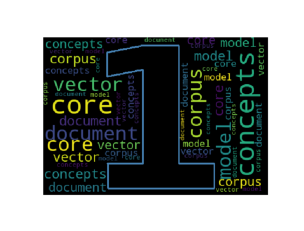

In [50]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
os.chdir('E:/excise/python/new_project01/com/data_analysis/gensim_/core_concepts')
img = mpimg.imread('run_core_concepts.png')
imgplot = plt.imshow(img)
_ = plt.axis('off')